# BETH Dataset EDA

>The BETH dataset currently represents 8,004,918 events collected over 23 honeypots, running for about five noncontiguous hours on a major cloud provider. For benchmarking and discussion, we selected the initial subset of the process logs. This subset was further divided into training, validation, and testing sets with a rough 60/20/20 split based on host, quantity of logs generated, and the activity logged—only the test set includes an attack
>
>The dataset is composed of two sensor logs: kernel-level process calls and network traffic. The initial benchmark subset only includes process logs. Each process call consists of 14 raw features and 2 hand-crafted labels.

This notebook is focused solely on the the network-traffic  data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # viz
import matplotlib.pyplot as plt # viz
from scipy import stats
import json
from typing import List, Tuple
from glob import glob
import networkx as nx
import ipaddress



import warnings
warnings.filterwarnings('ignore')

# Initial Explore
## Load Data

In [2]:
dns_data = glob("/kaggle/input/beth-dataset/*-dns.csv")
dns_data

['/kaggle/input/beth-dataset/labelled_2021may-ip-10-100-1-4-dns.csv',
 '/kaggle/input/beth-dataset/labelled_2021may-ip-10-100-1-186-dns.csv',
 '/kaggle/input/beth-dataset/labelled_2021may-ip-10-100-1-26-dns.csv',
 '/kaggle/input/beth-dataset/labelled_2021may-ip-10-100-1-105-dns.csv',
 '/kaggle/input/beth-dataset/labelled_2021may-ip-10-100-1-95-dns.csv',
 '/kaggle/input/beth-dataset/labelled_2021may-ubuntu-dns.csv']

In [3]:
df_all = []
for data in dns_data[:1]:
    df = pd.read_csv(data)
    df_all.append(df)
df_final = pd.concat(df_all, ignore_index=True)

In [4]:
df_final.head()

,Timestamp,SourceIP,DestinationIP,DnsQuery,DnsAnswer,DnsAnswerTTL,DnsQueryNames,DnsQueryClass,DnsQueryType,NumberOfAnswers,DnsResponseCode,DnsOpCode,SensorId,sus,evil
0,2021-05-16T17:13:14Z,10.100.1.95,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-95,0,0
1,2021-05-16T17:13:14Z,10.100.0.2,10.100.1.95,ssm.us-east-2.amazonaws.com,['52.95.19.240'],['17'],ssm.us-east-2.amazonaws.com,['IN'],['A'],1,0,0,ip-10-100-1-95,0,0
2,2021-05-16T17:13:14Z,10.100.1.95,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
3,2021-05-16T17:13:14Z,10.100.0.2,10.100.1.95,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
4,2021-05-16T17:13:16Z,10.100.1.186,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-186,0,0


In [5]:
df_final.describe()

,NumberOfAnswers,DnsResponseCode,DnsOpCode,sus,evil
count,269.000000,269.000000,269.0,269.000000,269.000000
mean,0.327138,0.066914,0.0,0.078067,0.014870
std,0.817741,0.443845,0.0,0.268777,0.121258
min,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.0,0.000000,0.000000
max,8.000000,3.000000,0.0,1.000000,1.000000


In [6]:
duplicateRows = df_final[df_final.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(len(duplicateRows))

Duplicate Rows except first occurrence based on all columns are :
10


In [7]:
df_final = df_final.drop_duplicates()

In [8]:
df_final.describe()

,NumberOfAnswers,DnsResponseCode,DnsOpCode,sus,evil
count,259.000000,259.000000,259.0,259.000000,259.000000
mean,0.339768,0.034749,0.0,0.073359,0.015444
std,0.830850,0.321619,0.0,0.261230,0.123549
min,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.500000,0.000000,0.0,0.000000,0.000000
max,8.000000,3.000000,0.0,1.000000,1.000000


<AxesSubplot:title={'center':'Label Frequency for evil label in Dataset'}>

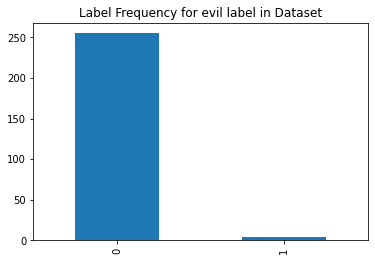

In [9]:
df_final.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Dataset')

<AxesSubplot:title={'center':'Label Frequency for sus label in Dataset'}>

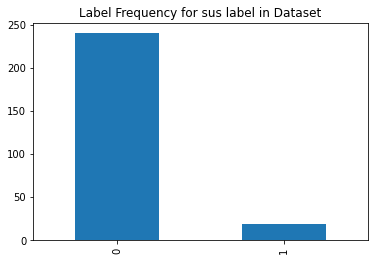

In [10]:
df_final.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Dataset')

In [11]:
df_final.groupby(['sus', 'evil'])[['Timestamp']].count()

Timestamp
sus evil           
0   0           240
1   0            15
    1             4

<AxesSubplot:xlabel='sus,evil'>

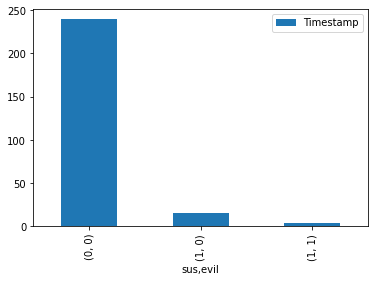

In [12]:
df_final.groupby(['sus', 'evil'])[['Timestamp']].count().plot(kind='bar')

<AxesSubplot:title={'center':'DnsQueryClass frequency in Dataset'}>

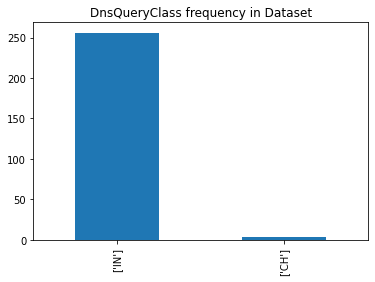

In [13]:
df_final.DnsQueryClass.value_counts().plot(kind='bar', title='DnsQueryClass frequency in Dataset')

<AxesSubplot:title={'center':'DnsQueryClass frequency in Dataset'}>

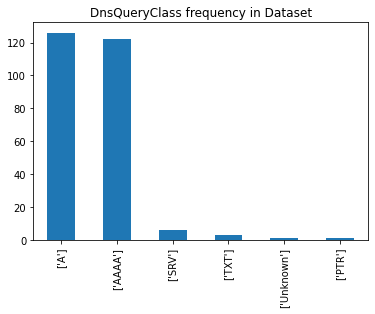

In [14]:
df_final.DnsQueryType.value_counts().plot(kind='bar', title='DnsQueryClass frequency in Dataset')

## What is the correlation of features across each dataset?

In [15]:
G = nx.from_pandas_edgelist(df_final, source="SourceIP", target="DestinationIP", edge_attr=True, create_using=nx.MultiDiGraph())


In [16]:
src_attributes = [ "DnsQueryClass","DnsQueryType", "sus", "evil"]

# Iterate over df rows and set source node attributes:
for index, row in df_final.iterrows():
    src_attr_dict = {k: row.to_dict()[k] for k in src_attributes}    
    G.nodes[row["SourceIP"]].update(src_attr_dict)
    G.nodes[row["DestinationIP"]].update(src_attr_dict)

In [17]:
# Check how many nodes the graph contains to set attributes for figure size
n = len(G.nodes)
if n > 1000:
    largegraph=True
    fig_size = (50,40)
    print("Large Graph: %s , using large graph functions" % n)
if n <= 500 > 999:
    fig_size = (40,30)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n <= 250  > 499 :
    fig_size = (30,20)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n < 100 > 0:
    fig_size = (18,15)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))

Small Graph: 15 figsize: (18, 15)


In [18]:
print("Graph analysis\n")
print("Multi-edge directed Graph\n")
print("Number of nodes: %s\t" % len(G.nodes))
print("Number of edges: %s\n" % len(G.edges))
print("Graph density: %s\n" % nx.density(G))
print("Graph is directed: %s\n" % G.is_directed())
print("Graph is weighted: %s\n" % nx.is_weighted(G))


Graph analysis

Multi-edge directed Graph

Number of nodes: 15	
Number of edges: 259

Graph density: 1.2333333333333334

Graph is directed: True

Graph is weighted: False



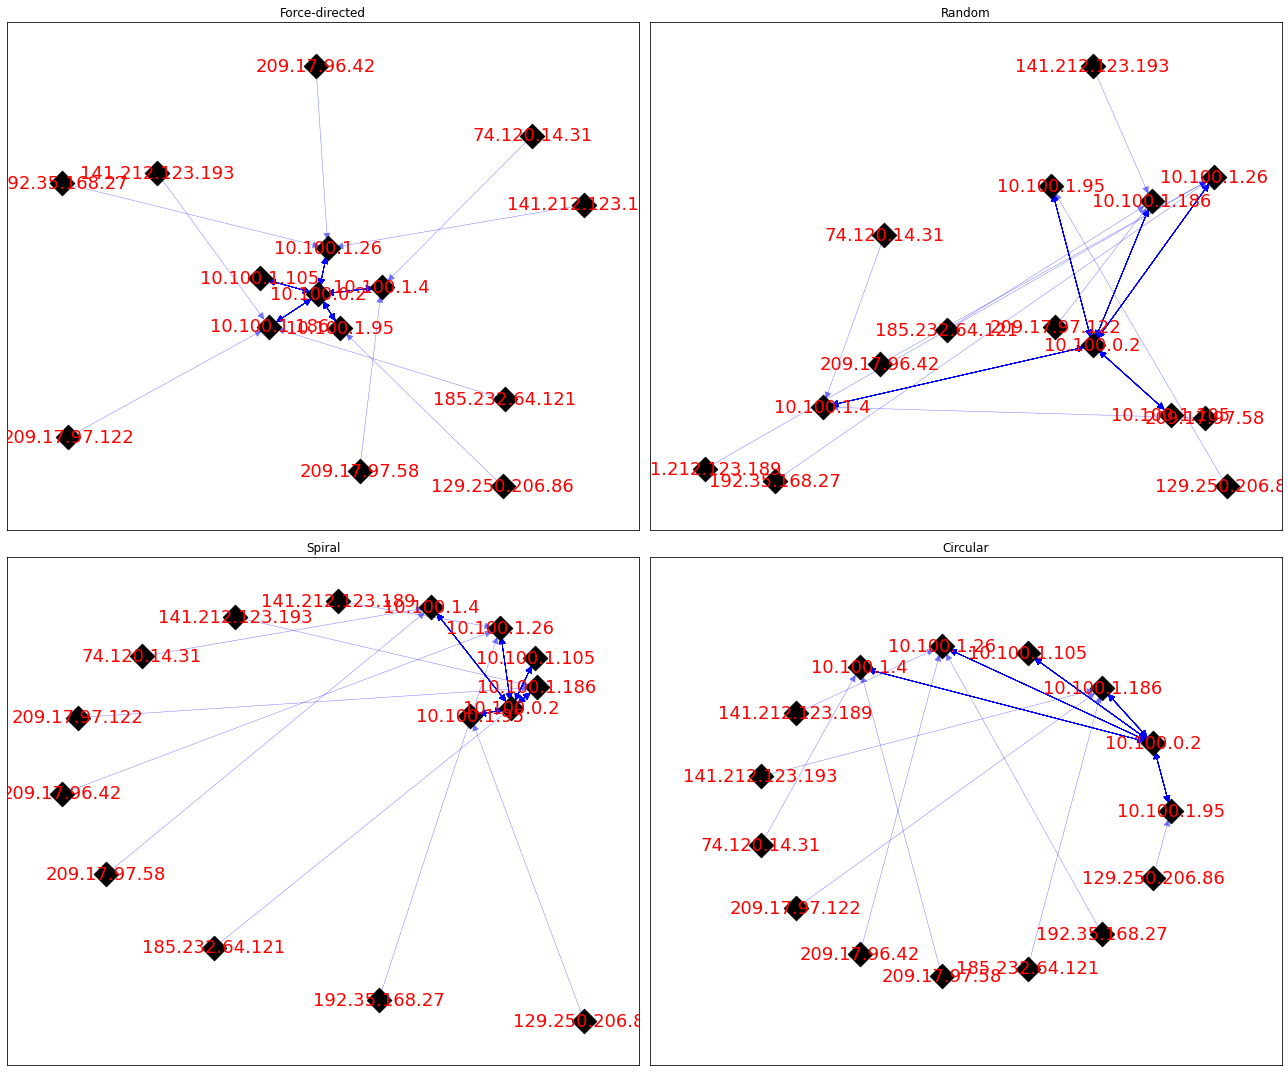

In [19]:
# Draw our graph
#Define our Graph Plot Layouts
layouts = (nx.spring_layout, nx.random_layout, nx.spiral_layout, nx.circular_layout)
title = ("Force-directed", "Random", "Spiral", "Circular")
## Create our Plots
# Create 4 subplots with the figure size based on graph size
_, plot = plt.subplots(2, 2, figsize=fig_size)
subplots = plot.reshape(1, 4)[0]
# Draw a plot for each layout
for plot, layout, title in zip(subplots, layouts, title):
    pos = layout(G)
    nx.draw_networkx_edges(G, pos, ax=plot, width=0.5, style="solid", edge_color="blue", alpha=0.5, arrows=True, arrowsize=15, arrowstyle="-|>")
    nx.draw_networkx_nodes(G, pos, ax=plot, node_color="black", node_shape="D")
    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=plot, font_color="red", font_size=18)
    plot.set_title(title)
# Draw with tight layout https://matplotlib.org/tutorials/intermediate/tight_layout_guide.html
plt.gca().margins(0.20, 0.20)
plt.tight_layout()
plt.show(block=False)

In [20]:
G.nodes(data=True) 

NodeDataView({'10.100.1.95': {'DnsQueryClass': "['IN']", 'DnsQueryType': "['AAAA']", 'sus': 0, 'evil': 0}, '10.100.0.2': {'DnsQueryClass': "['IN']", 'DnsQueryType': "['AAAA']", 'sus': 0, 'evil': 0}, '10.100.1.186': {'DnsQueryClass': "['IN']", 'DnsQueryType': "['AAAA']", 'sus': 0, 'evil': 0}, '10.100.1.105': {'DnsQueryClass': "['IN']", 'DnsQueryType': "['AAAA']", 'sus': 0, 'evil': 0}, '10.100.1.26': {'DnsQueryClass': "['IN']", 'DnsQueryType': "['AAAA']", 'sus': 0, 'evil': 0}, '10.100.1.4': {'DnsQueryClass': "['IN']", 'DnsQueryType': "['AAAA']", 'sus': 0, 'evil': 0}, '141.212.123.189': {'DnsQueryClass': "['IN']", 'DnsQueryType': "['A']", 'sus': 1, 'evil': 0}, '141.212.123.193': {'DnsQueryClass': "['IN']", 'DnsQueryType': "['A']", 'sus': 1, 'evil': 0}, '74.120.14.31': {'DnsQueryClass': "['IN']", 'DnsQueryType': "['PTR']", 'sus': 1, 'evil': 0}, '209.17.97.122': {'DnsQueryClass': "['CH']", 'DnsQueryType': "['TXT']", 'sus': 1, 'evil': 0}, '209.17.96.42': {'DnsQueryClass': "['CH']", 'DnsQuery

In [21]:
private_ips = [ip for ip in G.nodes if ipaddress.ip_address(ip).is_private]
global_ips = [ip for ip in list(G.nodes) if ipaddress.ip_address(ip).is_global]
reserved_ips = [ip for ip in G.nodes if ipaddress.ip_address(ip).is_reserved]

sus_evil_00 = [(u, v) for (u, v, d) in G.in_edges(data=True) if (d["sus"] == 0) and (d["evil"] == 0)]
sus_evil_10 = [(u, v) for (u, v, d) in G.out_edges(data=True) if (d["sus"] == 1) and (d["evil"] == 0)]
sus_evil_11 = [(u, v) for (u, v, d) in G.in_edges(data=True) if (d["sus"] == 1) and (d["evil"] == 1) ]

In [22]:
# sus_evil_00

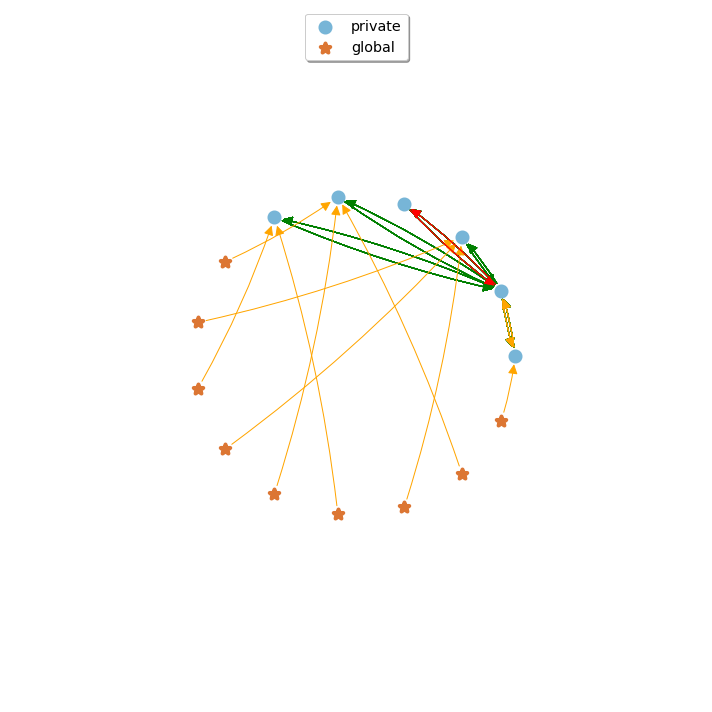

In [23]:
plt.figure(figsize=(10,10))


# Draw the type of node on top of each node, for global, private and reserved IP's
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=private_ips,
                       node_color='#77B5D7', 
                       node_shape='o',
                       linewidths=4,
                       alpha=1,
                       label='private',
                       node_size=100)
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=global_ips, 
                       node_color='#DC7633', 
                       node_shape='*',  
                       linewidths=4,
                       alpha=1,
                       label='global',
                       node_size=100)


nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=reserved_ips, 
                       node_color='#C0392B', 
                       node_shape='P',  
                       linewidths=4,
                       alpha=1,
                       label='reserved',
                       node_size=100)

nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=sus_evil_00, 
                       width=1, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='green',
                       alpha=1, 
                       label='00',
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=3.0,
                       min_target_margin=3.0)

# nx.draw_networkx_edge_labels(G, 
#                              pos, 
#                              edge_labels=sus_evil_10, 
#                              label_pos=0.9, 
#                              font_color='#229954', 
#                              font_size=8)

nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=sus_evil_10, 
                       width=1, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='orange',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='10',
                       min_source_margin=3.0,
                       min_target_margin=3.0)


nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=sus_evil_11, 
                       width=1, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='red',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='11',
                       min_source_margin=3.0,
                       min_target_margin=3.0)


# Draw without box lines
plt.box(on=None)
# Draw legend
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
# Set margins
plt.gca().margins(0.5, 0.5)
# Set tight layout
plt.tight_layout()
plt.show()